# Computer Vision using Pytorch

## 0 Library and setup
* `torchvision` -> Base domain library for Pytorch Computer Vision
* `torchvision.datasets` -> get datasets and data loading functions for Computer Vision
* `torchvision.models` -> get pretrained Computer Vision models
* `torchvision.transforms` -> functions for manipulating visual data
* `torch.utils.data.Dataset` -> Base dataset class
* `torch.utils.data.DataLoader` -> Create a iterable dataset

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.0 MB/s eta 0:00:00


In [3]:
import torch
from torch import nn
from torch import optim
import torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from pathlib import Path

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [4]:
# setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [5]:
# timer to messure time of code block excuted
import time
class timer:
  def __init__(self):
    self.elapsed = None
  def __enter__(self):
    self.start = time.perf_counter()
    return self

  def __exit__(self, *exc):
    self.finish = time.perf_counter()
    self.elapsed = self.finish - self.start

with timer() as t:
  time.sleep(2)

print(t.elapsed)


2.001547670000008


## 1 Dataset

### 1.1 Download dataset

In [6]:
train_data = datasets.MNIST(root='dataset',
                               train=True,
                               download=True,
                               transform=v2.ToTensor(),
                               target_transform=None)
test_data = datasets.MNIST(root='dataset',
                              train=False,
                              transform=v2.ToTensor(),
                              target_transform=None,
                              download=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
100%|██████████| 9912422/9912422 [00:00<00:00, 67820137.78it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 94195718.37it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43103362.42it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 9645837.35it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



### 1.2 Check Dataset

In [7]:
print(f"Train Dataset: {train_data}\n\n Test Dataset: {test_data}")

Train Dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

 Test Dataset: Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset
    Split: Test
    StandardTransform
Transform: ToTensor()


In [8]:
train_features = train_data.data
train_labels = train_data.targets
classes = train_data.classes
class_to_idx = train_data.class_to_idx

print(f"Size of train dataset: {len(train_data)} images")
print(f"Size of test dataset: {len(test_data)} images")
print(f"Shape of train features: {train_features.shape}")
print(f"Shape of train labels: {train_labels.shape}")
print(f"Labels: {classes}")
print(f"label to Index: {class_to_idx}")
print(train_features.dtype, train_labels.dtype)

Size of train dataset: 60000 images
Size of test dataset: 10000 images
Shape of train features: torch.Size([60000, 28, 28])
Shape of train labels: torch.Size([60000])
Labels: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
label to Index: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
torch.uint8 torch.int64


In [9]:
features_0, label_0 = train_data[0]
print(f"Shape of features: {features_0.shape} -> [channel, height, weight]")
print(f"Data type of feature {features_0.dtype}, label: {torch.tensor(label_0).dtype}")

Shape of features: torch.Size([1, 28, 28]) -> [channel, height, weight]
Data type of feature torch.float32, label: torch.int64


### 1.3 Visualize data

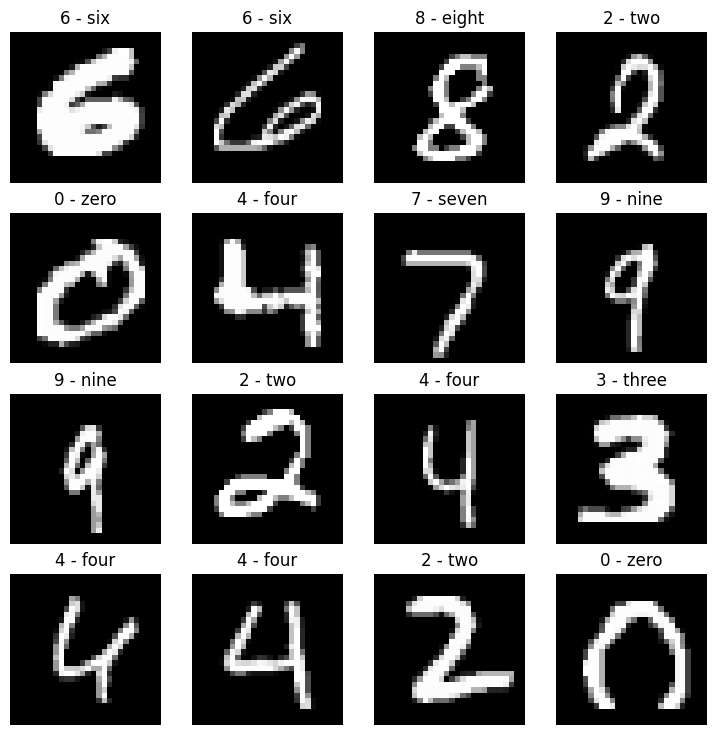

In [10]:
torch.manual_seed(42)
rows, cols = 4, 4
fig = plt.figure(figsize=(9, 9))
for i in range(1, rows * cols + 1):
  id = torch.randint(0, len(train_data), size=[])
  image, label = train_data[id]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(train_data.classes[label])
  plt.axis(False)

### 1.4 DataLoader

> Using mini-batch Gradient Descent to:
* Computational Efficient: if dataset is big (ex: milion, ...), it quite slow to process
* Take more chances for gradient descent per epoch.

In [11]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [12]:
train_dataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
print(f"Size of train data loader {len(train_dataloader)} batches of {train_dataloader.batch_size} samples")
print(f"Size of train data loader {len(test_dataloader)} batches of {test_dataloader.batch_size} samples")

Size of train data loader 1875 batches of 32 samples
Size of train data loader 313 batches of 32 samples


In [14]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))

In [15]:
print(f"Shape of one batch in data loader, \nfeatures: {train_feature_batch.shape},\nlabels: {train_label_batch.shape}")

Shape of one batch in data loader, 
features: torch.Size([32, 1, 28, 28]),
labels: torch.Size([32])


## 2 Buld Model

### 2.1 Dense Model

> *flatten -> linear -> relu > linear*

In [16]:
class Model_v1(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = in_features, out_features = out_features),
    )

  def forward(self, X):
    return self.layer_stack(X)

In [17]:
class Model_v2(nn.Module):
  def __init__(self, in_features, hidden_units, out_features):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = in_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = out_features),
    )

  def forward(self, X):
    return self.layer_stack(X)

### 2.2 CNN model

[CNN Explainer](https://poloclub.github.io/cnn-explainer/)

*TinyCNN*
> **input -> BLOCK_1[conv1.1 -> relu1.1 -> conv1.2 -> relu1.2 -> max_pool1] -> BLOCK_2[conv2.1 -> relu2.1 -> conv2.2 -> relu2.2 -> max_pool2] -> DENSE_BLOCK[flatten -> dense] -> softmax -> output**

In [18]:
class TinyCNN(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, out_features:int):
    super().__init__()
    self.cnn_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=0), # 10 x 26 x 26
        nn.ReLU(), #  10 x 26 x 26
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=0), # 10 x 24 x 24
        nn.ReLU(), #  10 x 24 x 24
        nn.MaxPool2d(kernel_size=2)) #  10 x 12 x 12

    self.cnn_block2 = nn.Sequential(
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=0), #  10 x 10 x 10
        nn.ReLU(), #  10 x 10 x 10
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=0), #  10 x 8 x 8
        nn.ReLU(), #  10 x 8 x 8
        nn.MaxPool2d(kernel_size=2)) #  10 x 4 x 4

    self.dense = nn.Sequential(
        nn.Flatten(), # 160
        nn.Linear(in_features=10 * 4 * 4, out_features=out_features) # 10
    )

  def forward(self, x):
    x = self.cnn_block1(x)
    x = self.cnn_block2(x)
    y_logit = self.dense(x)

    return y_logit


In [19]:
cnn = TinyCNN(1, 10, 10)
x = torch.randn(size=(1, 1, 28, 28))

y_logit = cnn(x)
print(y_logit)

tensor([[-0.1235,  0.0354, -0.0553, -0.0813, -0.0998, -0.1317, -0.0444,  0.0787,
          0.0766,  0.0574]], grad_fn=<AddmmBackward0>)


## 3 Train model

**Loop each epoch:**
1. Forward
2. Calculate loss
3. Gradient
4. Update model
5. Test model

In [20]:
def train_step(model: nn.Module, dataloader, criterion, optimizer, device='cpu'):
  loss = torch.tensor(0., device=device)
  acc = torch.tensor(0., device=device)
  model.to(device)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # forward
    y_hat = model(X)

    # Compute loss and accuracy
    loss_ = criterion(y_hat, y)
    loss += loss_
    acc += torchmetrics.functional.accuracy(y_hat, y, task='multiclass', num_classes=len(classes))

    # compute gradient
    optimizer.zero_grad()
    loss_.backward()

    # update model
    optimizer.step()

    if batch % 400 == 0:
      loss_batch = criterion(y_hat, y) / BATCH_SIZE
      acc_batch = torchmetrics.functional.accuracy(y_hat, y, task='multiclass', num_classes=len(classes))
      print(f"[{batch * BATCH_SIZE}/{len(dataloader) * BATCH_SIZE}] - [Loss: {loss_batch:.5f}/Accuracy: {acc_batch * 100:.2f}%]")

  print(f"Accuracy: {acc/len(dataloader) * 100:.2f} - loss: {loss/len(dataloader):.2f}")

In [21]:
def test_step(model: nn.Module, dataloader, criterion, device='cpu'):
  loss = torch.tensor(0., device=device)
  acc = torch.tensor(0., device=device)
  model.to(device)
  model.eval()

  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    # forward
    y_hat = model(X)

    # Compute loss and accuracy
    loss_ = criterion(y_hat, y)
    loss += loss_
    acc += torchmetrics.functional.accuracy(y_hat, y, task='multiclass', num_classes=len(classes))

  print(f"Accuracy: {acc/len(dataloader) * 100:.2f} - loss: {loss/len(dataloader):.2f}")

In [22]:
def trainer(model: nn.Module, train_dataloader, test_dataloader, criterion, optimizer, epochs = 10, device='cpu'):
  print(f"Training on {device} device")
  for epoch in range(epochs):
    print(f"Epoch {epoch}\n-----------")
    print('Train ...')
    train_step(model, train_dataloader, criterion, optimizer)
    print('Test ...')
    test_step(model, test_dataloader, criterion)


### model v1

Epoch 0
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 89.76 - loss: 0.37
Test ...
Accuracy: 90.46 - loss: 0.35
Epoch 1
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 91.04 - loss: 0.34
Test ...
Accuracy: 90.51 - loss: 0.36
Epoch 2
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 91.18 - loss: 0.33
Test ...
Accuracy: 90.97 - loss: 0.35
Epoch 3
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 91.41 - loss: 0.33
Test ...
Accuracy: 91.49 - loss: 0.35
Epoch 4
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 91.42 - loss: 0.32
Test ...
Accuracy: 91.65 - loss: 0.34
Epoch 5
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 91.49 - loss: 0.32
Test ...
Accuracy: 91.83 - loss: 0.34
Epoch 6
-----------
Tr

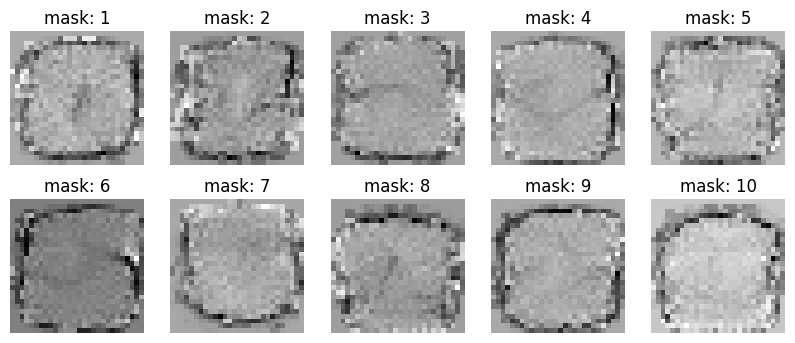

In [ ]:
epochs = 10

in_features = len(train_data[0][0].flatten())
out_features = len(classes)

modelv1 = Model_v1(in_features = in_features,
                      out_features = out_features).to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = modelv1.parameters(), lr = 0.01)


trainer(modelv1, train_dataloader, test_dataloader, criterion, optimizer, epochs=epochs)

# visualize
mask = modelv1.state_dict()['layer_stack.1.weight'].to('cpu')
fig = plt.figure(figsize=(10, 4))
nrows, ncols = 2, 5

for i in range(1, nrows * ncols + 1):
  fig.add_subplot(nrows, ncols, i)
  plt.imshow(mask[i-1].reshape((28, 28)), cmap='gray')
  plt.title(f'mask: {i-1}')
  plt.axis(False)

In [ ]:
modelv1.state_dict()['layer_stack.1.weight'].shape, train_data[0][0].flatten().shape

(torch.Size([10, 784]), torch.Size([784]))

In [ ]:
id = 4
a = torch.matmul(modelv1.state_dict()['layer_stack.1.weight'], train_data[id][0].flatten().to(device))
train_data[id][1], a, a.softmax(0) * 100, a.argmax()

(9,
 tensor([-23.0477, -15.2480, -19.0022,  -6.8527,   2.0054,  -8.2755, -23.8754,
           0.1185,   1.3090,   6.5395], device='cuda:0'),
 tensor([1.3893e-11, 3.3901e-08, 7.9391e-10, 1.5005e-04, 1.0550e+00, 3.6165e-05,
         6.0725e-12, 1.5987e-01, 5.2579e-01, 9.8259e+01], device='cuda:0'),
 tensor(9, device='cuda:0'))

### model v2

Epoch 0
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 92.70 - loss: 0.24
Test ...
Accuracy: 95.04 - loss: 0.18
Epoch 1
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 95.54 - loss: 0.16
Test ...
Accuracy: 95.51 - loss: 0.18
Epoch 2
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 96.15 - loss: 0.14
Test ...
Accuracy: 96.21 - loss: 0.15
Epoch 3
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 96.47 - loss: 0.13
Test ...
Accuracy: 95.76 - loss: 0.18
Epoch 4
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 96.68 - loss: 0.12
Test ...
Accuracy: 96.11 - loss: 0.19
Epoch 5
-----------
Train ...
[0/60000]
[12800/60000]
[25600/60000]
[38400/60000]
[51200/60000]
Accuracy: 97.04 - loss: 0.12
Test ...
Accuracy: 96.53 - loss: 0.16
Epoch 6
-----------
Tr

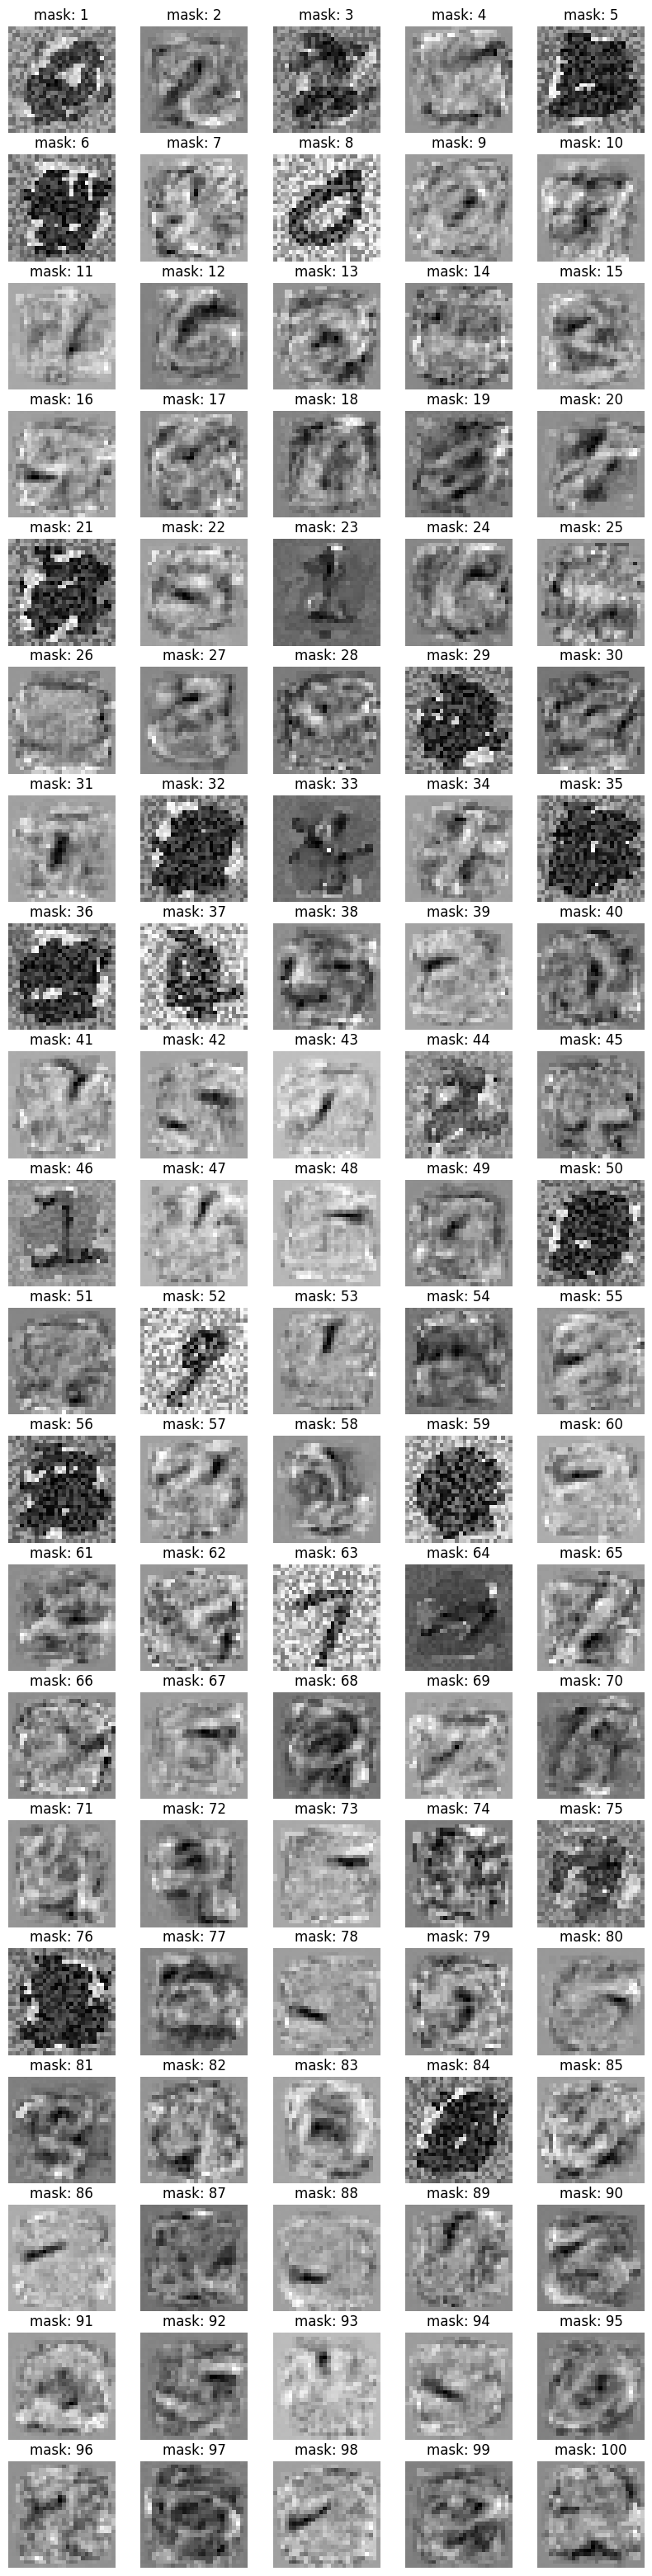

In [ ]:
epochs = 10

in_features = len(train_data[0][0].flatten())
hidden_units = 100
out_features = len(classes)

modelv2 = Model_v2(in_features = in_features,
                   hidden_units = hidden_units,
                   out_features = out_features).to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = modelv2.parameters(), lr = 0.01)


trainer(modelv2, train_dataloader, test_dataloader, criterion, optimizer, epochs=epochs)

# visualize
mask = modelv2.state_dict()['layer_stack.1.weight'].to('cpu')
fig = plt.figure(figsize=(10, 40))
nrows, ncols = 20, 5

for i in range(1, nrows * ncols + 1):
  fig.add_subplot(nrows, ncols, i)
  plt.imshow(mask[i-1].reshape((28, 28)), cmap='gray')
  plt.title(f'mask: {i}')
  plt.axis(False)

### cnn model

In [ ]:
epochs = 5

cnn_model = TinyCNN(in_channels = 1,
                      out_channels = 10, out_features=10).to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = cnn_model.parameters(), lr = 0.01)


trainer(cnn_model, train_dataloader, test_dataloader, criterion, optimizer, epochs=epochs, device=device)


Training on cuda device
Epoch 0
-----------
Train ...
[0/60000] - [Loss: 0.07198/Accuracy: 12.50%]
[12800/60000] - [Loss: 0.01449/Accuracy: 87.50%]
[25600/60000] - [Loss: 0.00260/Accuracy: 96.88%]
[38400/60000] - [Loss: 0.00807/Accuracy: 93.75%]
[51200/60000] - [Loss: 0.00965/Accuracy: 96.88%]
Accuracy: 93.55 - loss: 0.21
Test ...
Accuracy: 96.68 - loss: 0.12
Epoch 1
-----------
Train ...
[0/60000] - [Loss: 0.00247/Accuracy: 93.75%]
[12800/60000] - [Loss: 0.01010/Accuracy: 90.62%]
[25600/60000] - [Loss: 0.00197/Accuracy: 96.88%]
[38400/60000] - [Loss: 0.01203/Accuracy: 90.62%]


## 4 Inference

In [ ]:
def make_predictions(model: nn.Module, samples: list[torch.Tensor], device: torch.device = 'cpu'):
  pred = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in samples:
      y_logit = model(sample.unsqueeze(0).to(device))
      y_prob = torch.softmax(y_logit, 1)
      y_pred = y_prob.argmax(dim=1)
      pred.append(y_pred)
  return list(torch.cat(pred).cpu().numpy())

[4, 9, 0, 5, 1, 0, 8, 3, 1]
[4, 9, 0, 5, 1, 0, 8, 3, 1]


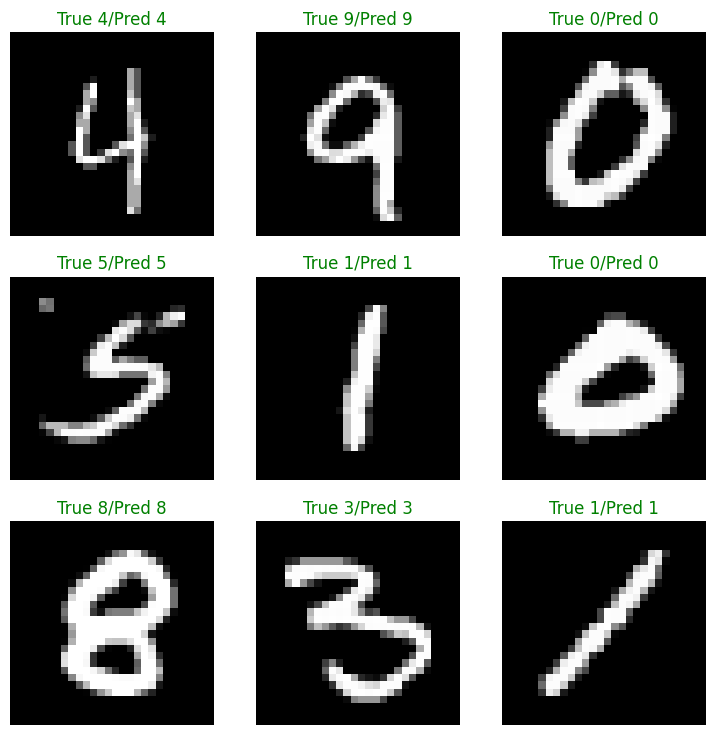

In [ ]:
import random

test_samples = []
true_labels = []

for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  true_labels.append(label)

pred = make_prediction(cnn_model, test_samples, device='cuda')

print(true_labels)
print(pred)

fig = plt.figure(figsize = (9, 9))
nrow, ncol = 3, 3
for i in range(1, nrow * ncol + 1):
  fig.add_subplot(nrow, ncol, i)
  plt.imshow(test_samples[i-1].squeeze(), cmap='gray')
  if pred[i-1] == true_labels[i-1]:
    plt.title(f"True {true_labels[i-1]}/Pred {pred[i-1]}", c='green')
  else:
    plt.title(f"True {true_labels[i-1]}/Pred {pred[i-1]}", c='red')
  plt.axis(False)

## 5 Evaluation

In [ ]:
test_step(cnn_model, test_dataloader, criterion)

Accuracy: 97.73 - loss: 0.07


In [ ]:
samples = [sample[0] for sample in list(test_data)]
preds = make_predictions(cnn_model, samples)
type(preds)

list

In [ ]:
test_data.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

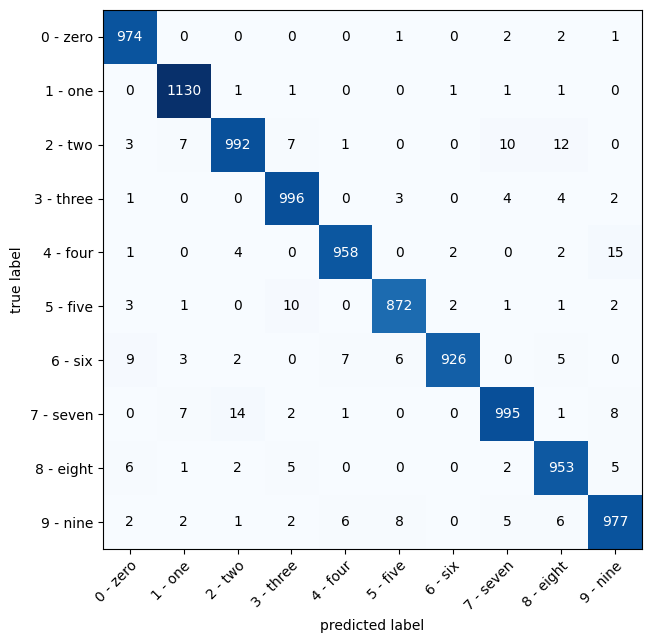

In [ ]:
# Confusion matrix
samples = [sample[0] for sample in list(test_data)]
preds = torch.tensor(make_predictions(cnn_model, samples))
targets = test_data.targets

cm = ConfusionMatrix(num_classes=10, task='multiclass')
tensor_cm = cm(preds, targets)

fig, ax = plot_confusion_matrix(
    conf_mat = tensor_cm.numpy(),
    class_names = classes,
    figsize = (10, 7)
)

## 6 Save and load model

In [ ]:
# Save state dict of model
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)

model_name = 'tinycnn_mnist.pth'
path = model_path / model_name

print(f"Saving model to {path}")

torch.save(obj=cnn_model.state_dict(), f=path)

print("Done!!!")

Saving model to models/tinycnn_mnist.pth
Done!!!


In [ ]:
# load state dict of model

# create an instance
ins_cnn = TinyCNN(1, 10, 10)
print(f"Loading ...")
cnn.load_state_dict(torch.load(f=path))
print("Complete !!!")

Loading ...
Complete !!!


In [ ]:
test_id = 5
ins_cnn(test_data[test_id][0].unsqueeze(0)).softmax(1).argmax().item()

9

## 7 Visualize CNN

torch.Size([1, 28, 28])

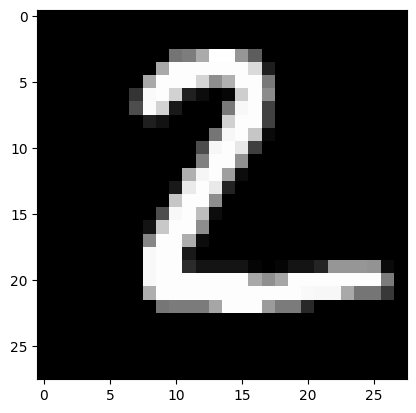

In [68]:
image = test_data[1][0]

plt.imshow(image.squeeze(), cmap='gray')
image.shape

In [69]:
cnn_arc = cnn_model.state_dict()
for layer in cnn_arc.keys():
  print(layer)

cnn_block1.0.weight
cnn_block1.0.bias
cnn_block1.2.weight
cnn_block1.2.bias
cnn_block2.0.weight
cnn_block2.0.bias
cnn_block2.2.weight
cnn_block2.2.bias
dense.1.weight
dense.1.bias


In [76]:
cnn_arc['cnn_block2.0.weight'].shape

torch.Size([10, 10, 3, 3])

In [70]:
in_channels = 1
out_channels = 10

conv11 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=0)
conv12 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=0)
conv21 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=0) #  10 x 10 x 10
conv22 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=0) #  10 x 8 x 8
linear = nn.Linear(in_features=10 * 4 * 4, out_features=10)


conv11.load_state_dict(state_dict={'weight': cnn_arc['cnn_block1.0.weight'],
                                 'bias': cnn_arc['cnn_block1.0.bias']})
conv12.load_state_dict(state_dict={'weight': cnn_arc['cnn_block1.2.weight'],
                                 'bias': cnn_arc['cnn_block1.2.bias']})
conv21.load_state_dict(state_dict={'weight': cnn_arc['cnn_block2.0.weight'],
                                 'bias': cnn_arc['cnn_block2.0.bias']})
conv22.load_state_dict(state_dict={'weight': cnn_arc['cnn_block2.2.weight'],
                                 'bias': cnn_arc['cnn_block2.2.bias']})
linear.load_state_dict(state_dict={'weight': cnn_arc['dense.1.weight'],
                                   'bias': cnn_arc['dense.1.bias']})


<All keys matched successfully>

In [71]:
# cnn block 1
fm11 = conv11(image.unsqueeze(dim=0)) # 26
fm11relu = nn.ReLU()(fm11)
fm12 = conv12(fm11relu) #24
fm12relu = nn.ReLU()(fm12)
fm12relupool = nn.MaxPool2d(kernel_size=2)(fm12relu) #12

# cnn block 2
fm21 = conv21(fm12relupool) # 10
fm21relu = nn.ReLU()(fm21)
fm22 = conv22(fm21relu) # 8
fm22relu = nn.ReLU()(fm22)
fm22relupool = nn.MaxPool2d(kernel_size=2)(fm22relu) # 4

# classifier
flatten = nn.Flatten()(fm22relupool)
logit = linear(flatten)
prob = nn.Softmax(dim=1)(logit)
prediction = prob.argmax()

In [72]:
logit, prob, prediction

(tensor([[ -3.8484,   0.5559,  10.4558,  -1.1068,  -4.5838, -21.6314,  -5.6300,
          -18.0233,  -0.7896, -11.5875]], grad_fn=<AddmmBackward0>),
 tensor([[6.1344e-07, 5.0179e-05, 9.9993e-01, 9.5148e-06, 2.9401e-07, 1.1606e-14,
          1.0328e-07, 4.2821e-13, 1.3067e-05, 2.6711e-10]],
        grad_fn=<SoftmaxBackward0>),
 tensor(2))

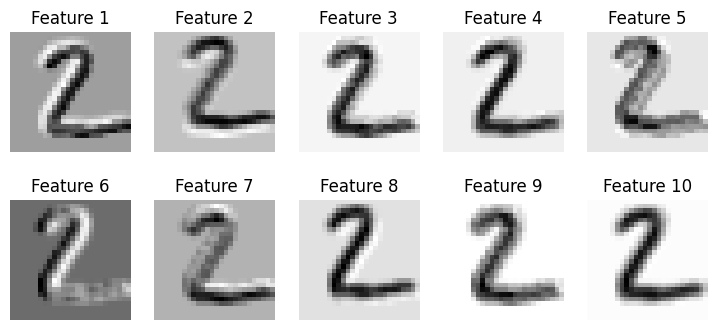

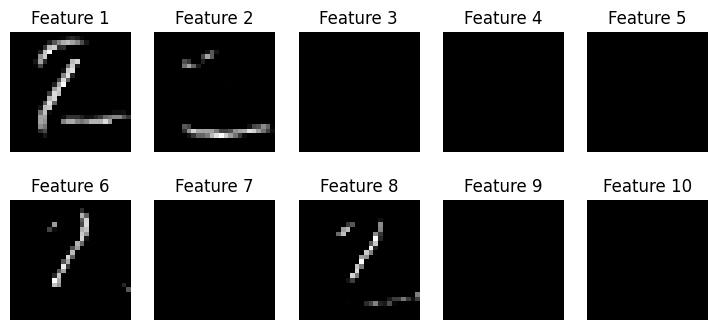

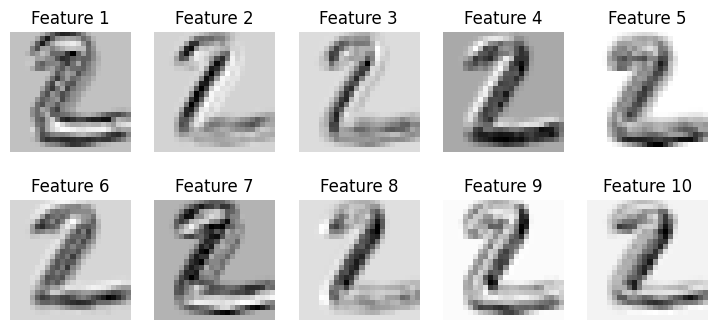

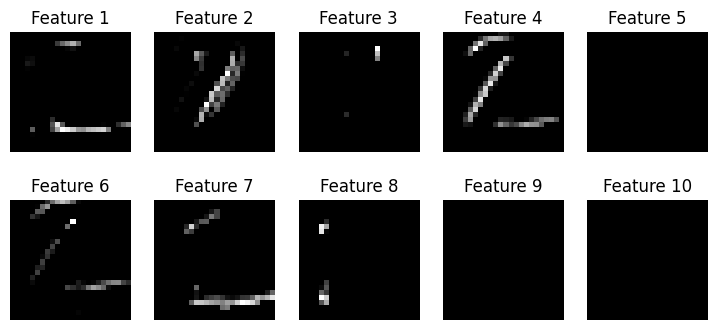

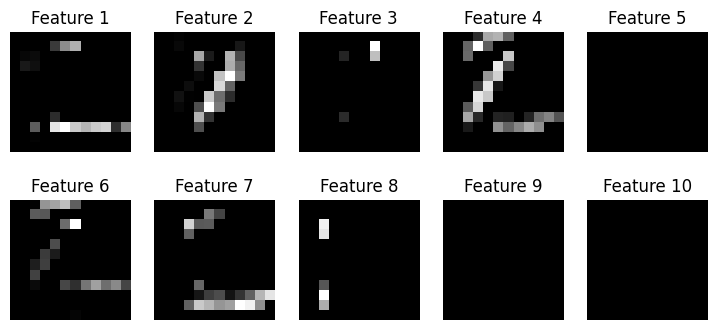

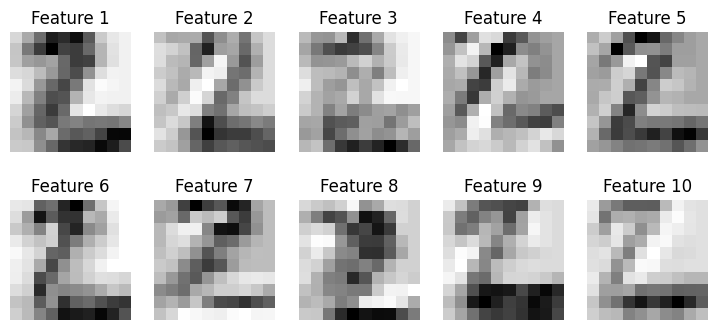

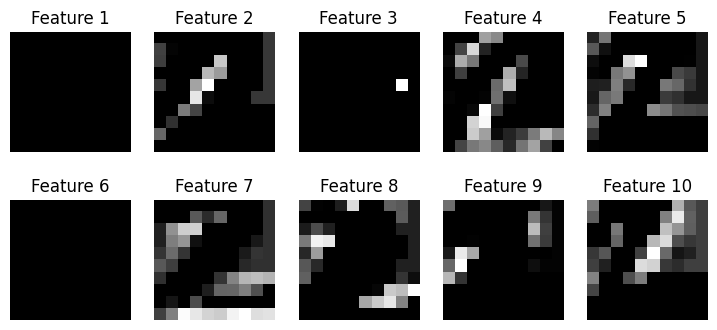

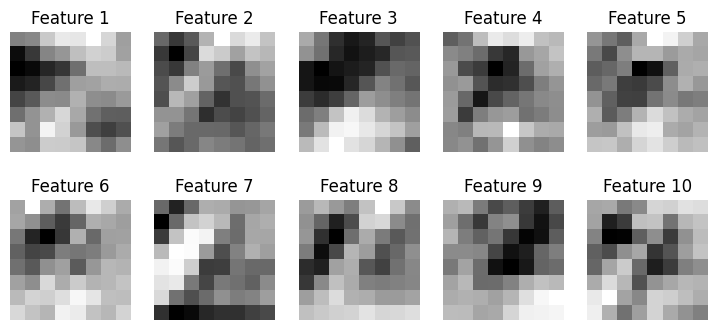

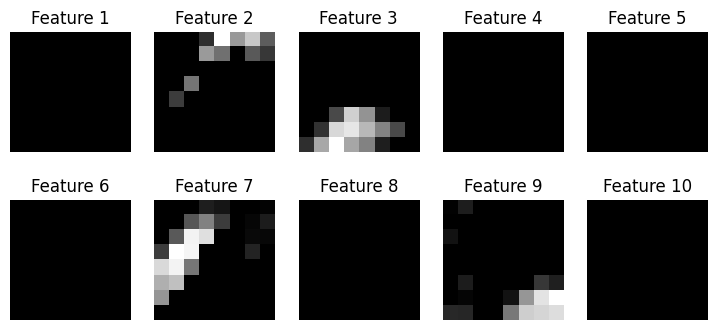

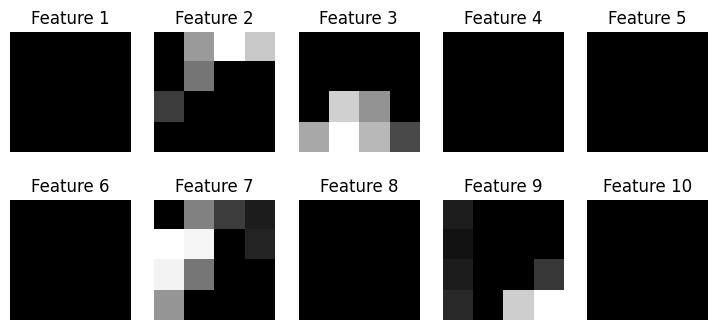

In [75]:
feature_maps = [fm11, fm11relu, fm12, fm12relu, fm12relupool, fm21, fm21relu, fm22, fm22relu, fm22relupool]

for feature_map in feature_maps:
  fig = plt.figure(figsize=(9, 4))
  nrow, ncol = 2, 5
  for i in range(1, nrow * ncol + 1):
    fig.add_subplot(nrow, ncol, i)
    plt.imshow(feature_map[0][i-1].detach().numpy(), cmap='gray')
    plt.title(f"Feature {i}")
    plt.axis(False)